In [1]:
import numpy as np
import pandas as pd
import random as rand
import requests
import json
import re
from json import loads

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import math
import gurobipy as gp
from gurobipy import GRB
from datetime import datetime

In [8]:
class after_settlement():
    
    def __init__(self,num,src,dst,order,total_pay):
        self.num = num
        self.src = src
        self.dst = dst
        self.order = order
        self.total_pay = total_pay

        src.extend(order)
        routing = src

        loc_info = {i :[src[i]] for i in range(len(src))}
        self.loc_info = loc_info
        
        ### 출발지+도착지 좌표 POI
        for i in range(len(loc_info)):
            url = f"https://apis.openapi.sk.com/tmap/pois?version=1&searchKeyword={loc_info[i]}&searchType=all" \
                f"&searchtypCd=A&reqCoordType=WGS84GEO&resCoordType=WGS84GEO&page=1&count=1&multiPoint=N&poiGroupYn=N"

            headers = {
                "Accept": "application/json",
                "appKey": "l7xxcdd1a30a6b34450a881f8083994a8cd4"
            }

            response = requests.get(url, headers=headers)
            jsonObj = json.loads(response.text)
            loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLon']))
            loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLat']))
        
        addr_info = {loc_info[i][0] : {'no': i, 'lon': loc_info[i][1], 'lat': loc_info[i][2]} for i in range(len(loc_info))}
        ####################

        ### 직선거리 시각화
        passenger_sample = addr_info.keys()
        print(passenger_sample)

        if num == 2:
            src,a,b = passenger_sample
            pass_2_node = {'src': src, 'a': a, 'b': b}
            node_2_pass = {src: 'src', a: 'a', b: 'b'}
        elif num == 3:
            src,a,b,c = passenger_sample
            pass_2_node = {'src': src, 'a': a, 'b': b, 'c': c}
            node_2_pass = {src: 'src', a: 'a', b: 'b', c: 'c'}
        else:
            src,a,b,c,d = passenger_sample
            pass_2_node = {'src': src, 'a': a, 'b': b, 'c': c, 'd': d}
            node_2_pass = {src: 'src', a: 'a', b: 'b', c: 'c', d: 'd'}

        lat = [addr_info[addr]['lat'] for addr in passenger_sample]
        lon = [addr_info[addr]['lon'] for addr in passenger_sample]
        addr = [f'{pas}({node_2_pass[pas]})' for pas in passenger_sample]

        fig, ax = plt.subplots()
        ax.scatter(lon, lat)
        for i, txt in enumerate(addr):
            ax.annotate(txt, (lon[i], lat[i]))

        for i, txt in enumerate(addr):
            try:
                ax.plot([lon[0], lon[i+1]], [lat[0], lat[i+1]])
            except: pass
        
        plt.show()
        ####################

        lat2 = [addr_info[rou]['lat'] for rou in routing]
        lon2 = [addr_info[rou]['lon'] for rou in routing]

        ### 경유거리 시각화
        fig, ax = plt.subplots()
        ax.scatter(lon, lat)
        for i, txt in enumerate(routing):
            try:
                ax.plot([lon2[i], lon2[i+1]], [lat2[i], lat2[i+1]])
            except: pass
        for i, txt in enumerate(addr):
            ax.annotate(txt, (lon[i], lat[i]))
        plt.show()

        passenger_routing = routing
        ######################

        self.passenger_routing = passenger_routing

        ### move alone 시간, 요금 계산
        individual_distance = []
        individual_duration = []
        individual_cost = []

        url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

        for i in range(len(loc_info)-1):
            payload = {
                "tollgateFareOption": 16,
                "roadType": 32,
                "directionOption": 1,
                
                # j번째 승객의 하차지역
                "endX": addr_info[passenger_routing[i+1]]['lon'],
                "endY": addr_info[passenger_routing[i+1]]['lat'],
                ##
                "endRpFlag": "G",
                "reqCoordType": "WGS84GEO",        
                # 출발지역
                "startX": addr_info[passenger_routing[0]]['lon'],
                "startY": addr_info[passenger_routing[0]]['lat'],
                ##
                "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'), #YYYYMMDDhhmmss
                # "speed": 24, # 서울시 자동차 통행 속도
                "uncetaintyP": 1,
                "uncetaintyA": 1,
                "uncetaintyAP": 1,
                "carType": 0,
                "detailPosFlag": "2",
                "resCoordType": "WGS84GEO",
                "sort": "index",
                "searchOption": 0,
                "totalValue": 2,
                "trafficInfo": "Y", # 현재교통상황 반영
                "mainRoadInfo": "N"
            }
            headers = {
                "accept": "application/json",
                "content-type": "application/json",
                "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
            }
            response = requests.post(url, json=payload, headers=headers)
            jsonObj = json.loads(response.text)
            individual_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
            individual_duration.append(jsonObj['features'][0]['properties']['totalTime'])
            individual_cost.append(jsonObj['features'][0]['properties']['taxiFare'])
        #############################

        self.individual_distance = individual_distance
        self.individual_duration = individual_duration
        self.individual_cost = individual_cost

        ### move together 시간, 요금 계산
        routing_distance = []
        routing_duration = []
        routing_cost = []

        url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

        for j in range(1,len(loc_info)):
            # print('start')
            passlist = ''
            # 내리는 순서에 따라 경유지 들리는 횟수가 달라진다. >> 경유지 설정
            for i in range(1,j+1):
                if i==j:
                    break
                passlist += str(addr_info[passenger_routing[i]]['lon'])+','+str(addr_info[passenger_routing[i]]['lat'])
                if i!=j-1:
                    passlist += '_'
            ###
            payload = {
                "tollgateFareOption": 16,
                "roadType": 32,
                "directionOption": 1,

                # j번째 승객의 하차지역
                "endX": addr_info[passenger_routing[j]]['lon'],
                "endY": addr_info[passenger_routing[j]]['lat'],
                ###
                "endRpFlag": "G",
                "reqCoordType": "WGS84GEO",
                # 출발지역
                "startX": addr_info[passenger_routing[0]]['lon'],
                "startY": addr_info[passenger_routing[0]]['lat'],
                ###
                "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'),
                # "speed": 24,
                "uncetaintyP": 1,
                "uncetaintyA": 1,
                "uncetaintyAP": 1,
                "carType": 0,
                "detailPosFlag": "2",
                "resCoordType": "WGS84GEO",
                "sort": "index",
                "mainRoadInfo": "N",
                "trafficInfo": "Y", # 현재교통상황 반영
                "totalValue": 2
            }
            # passlist 없다면 pass
            if passlist!='':
                payload["passList"] = passlist
                ##
                headers = {
                    "accept": "application/json",
                    "content-type": "application/json",
                    "appKey": "l7xxcdd1a30a6b34450a881f8083994a8cd4"
                }
                # print(passlist)
                response = requests.post(url, json=payload, headers=headers)
                jsonObj = json.loads(response.text)

                routing_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
                routing_duration.append(jsonObj['features'][0]['properties']['totalTime'])
                routing_cost.append(jsonObj['features'][0]['properties']['taxiFare'])
            else: pass
            # print('end')

        # 첫번째 하차 승객 정보 추가
        routing_distance.insert(0,individual_distance[0])
        routing_duration.insert(0,individual_duration[0])
        routing_cost.insert(0,individual_cost[0]) 
        # 최종요금 보정
        routing_cost = [int(x/max(routing_cost)*total_pay) for x in routing_cost]
        #############################

        self.routing_distance = routing_distance
        self.routing_duration = routing_duration
        self.routing_cost = routing_cost

        # 지연 비율 >> 요금 정산에 필요
        delay_ratio = [(routing_duration[i]-individual_duration[i])/individual_duration[i] for i in range(len(loc_info)-1)]
        
        self.delay_ratio = delay_ratio


    def settlement_optimizer(self):


        LB = 0.4
        UB = 0.8

        num = self.num
        individual_cost = self.individual_cost
        delay_ratio = self.delay_ratio
        routing_cost = self.routing_cost

        if num == 2:
            # print('num==2')
            I1, I2 = individual_cost
            R1, R2 = delay_ratio
            T = routing_cost[-1]

            ## matching ALGorithm
            try:
                # Create a new model
                m = gp.Model('cost_optimization1')
                m.Params.LogToConsole = 0

                # Create variables
                alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
                beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

                # Set objective
                m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))-T, GRB.MINIMIZE)

                # Add constraint
                m.addConstr(max(R1,R2)*beta-UB*alpha <= 0,'const_1')
                m.addConstr(max(R1,R2)*beta-LB*alpha >= 0,'const_2')
                m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))-T >= 0,'const_3')

                m.addConstr(alpha <= 1)
                m.addConstr(alpha >= 0)
                m.addConstr(beta <= 1)
                m.addConstr(beta >= 0)
                #m.addConstr(gamma <= 1)

                # Optimize model
                m.optimize()

                for v in m.getVars():
                    print('%s : %g' % (v.varName, v.x))
                    globals()[v.varName] = v.x
                print(alpha)

            except gp.GurobiError as e:
                print('Error code ' + str(e.errno) + ': ' + str(e))

        elif num == 3:
            # print('num==3')
            I1, I2, I3 = individual_cost
            R1, R2, R3 = delay_ratio
            T = routing_cost[-1]

            ## matching ALGorithm
            try:
                # Create a new model
                m = gp.Model('cost_optimization1')
                m.Params.LogToConsole = 0

                # Create variables
                alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
                beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

                # Set objective
                m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T, GRB.MINIMIZE)

                # Add constraint
                m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
                m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
                m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T >= 0,'const_3')

                m.addConstr(alpha <= 1)
                m.addConstr(alpha >= 0)
                m.addConstr(beta <= 1)
                m.addConstr(beta >= 0)
                #m.addConstr(gamma <= 1)

                # Optimize model
                m.optimize()

                for v in m.getVars():
                    print('%s : %g' % (v.varName, v.x))
                    globals()[v.varName] = v.x
                print(alpha)

            except gp.GurobiError as e:
                print('Error code ' + str(e.errno) + ': ' + str(e))

        else:
            # print('num==4')
            I1, I2, I3, I4 = individual_cost
            R1, R2, R3, R4 = delay_ratio
            T = routing_cost[-1]

            ## matching ALGorithm
            try:
                # Create a new model
                m = gp.Model('cost_optimization1')
                m.Params.LogToConsole = 0

                # Create variables
                alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
                beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

                # Set objective
                m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))+I4*(1-(alpha+beta*R4))-T, GRB.MINIMIZE)

                # Add constraint
                m.addConstr(max(R1,R2,R3,R4)*beta-UB*alpha <= 0,'const_1')
                m.addConstr(max(R1,R2,R3,R4)*beta-LB*alpha >= 0,'const_2')
                m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))+I4*(1-(alpha+beta*R4))-T >= 0,'const_3')

                m.addConstr(alpha <= 1)
                m.addConstr(alpha >= 0)
                m.addConstr(beta <= 1)
                m.addConstr(beta >= 0)
                #m.addConstr(gamma <= 1)

                # Optimize model
                m.optimize()

                for v in m.getVars():
                    print('%s : %g' % (v.varName, v.x))
                    globals()[v.varName] = v.x
                print(alpha)

            except gp.GurobiError as e:
                print('Error code ' + str(e.errno) + ': ' + str(e))

    
    def result(self):
        loc_info = self.loc_info

        individual_distance = self.individual_distance
        individual_duration = self.individual_duration
        individual_cost = self.individual_cost
        passenger_routing = self.passenger_routing

        routing_distance = self.routing_distance
        routing_duration = self.routing_duration
        routing_cost = self.routing_cost
        delay_ratio = self.delay_ratio

        routing_individual_cost = [int((1-alpha-beta*delay_ratio[i])*individual_cost[i]) for i in range(len(loc_info)-1)]
        beta_prime = [beta*delay_ratio[i] for i in range(len(loc_info)-1)]

        print()
        for i in range(len(loc_info)-1):
            print(f'{passenger_routing[i+1]} : {alpha*100:.2f}+{beta*delay_ratio[i]*100:.2f} => {(alpha+beta_prime[i])*100:.2f}% 할인')
        print()
        for i in range(len(loc_info)-1):
            print(f'{passenger_routing[i+1]} : {individual_cost[i]} 원 >>> {routing_individual_cost[i]} 원')
        
        return {'passenger':passenger_routing, 'move_alone':individual_cost, 'move_together':routing_individual_cost,'paramter':{'alpha':alpha,'beta_prime':beta_prime}}

dict_keys(['서울역', '한양대역', '안암역'])


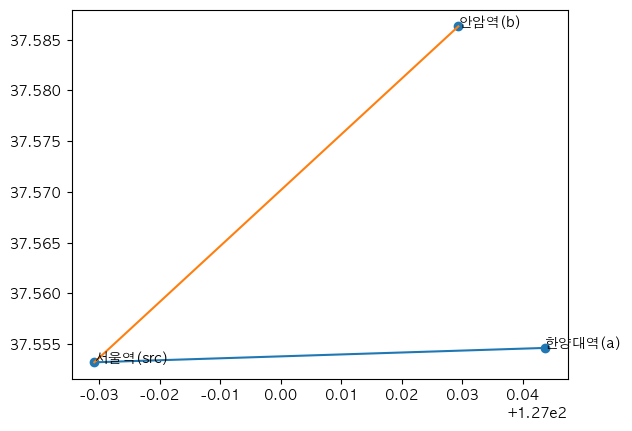

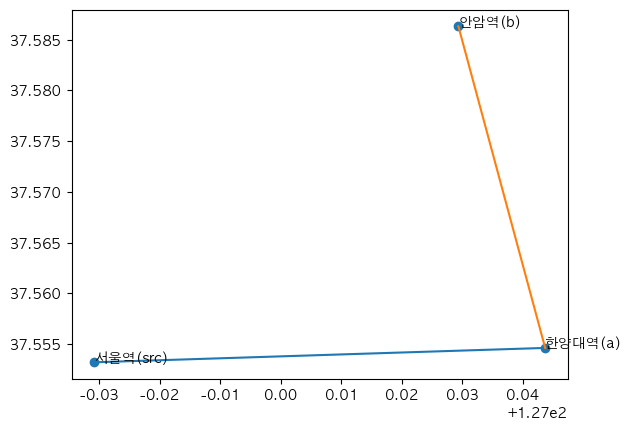

alpha : 0.196185
beta : 0.10365
<gurobi.Var alpha (value 0.19618528610354224)>

한양대역 : 19.62+0.00 => 19.62% 할인
안암역 : 19.62+7.85 => 27.47% 할인

한양대역 : 17100 원 >>> 13745 원
안암역 : 14000 원 >>> 10154 원
{'passenger': ['서울역', '한양대역', '안암역'], 'move_alone': [17100, 14000], 'move_together': [13745, 10154], 'paramter': {'alpha': 0.19618528610354224, 'beta_prime': [0.0, 0.0784741144414169]}}


In [11]:
if __name__ == "__main__":
    ### input data
    # 몇명
    num = 2 ## 2~4명
    # 출발지
    src = ['서울역']
    # 도착지
    dst = ['안암역','노원역','한양대역','화랑대역'][:num]
    order = ['한양대역','안암역','화랑대역','노원역'][:num]
    # 실제요금
    total_pay = [23900,34200,45400][num-2]


    set = after_settlement(num,src,dst,order,total_pay)
    set.settlement_optimizer()
    output = set.result()
    print()
    print(output)